In [2]:
!pip install -q transformers datasets tokenizers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Домашнее задание. Transformers.

Привет! Это очередное домашнее задание, но теперь ты познакомишься с моделя трансформеров и с библиотекой `HuggingFace🤗`. В этом задании будет предложено решить с помощью модели `GPT2` простую задачу (анализ сентимента) и сделать небольшое исследование карт внимания. Приступим!

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

import torch
import torch.nn as nn

from transformers import GPT2ForSequenceClassification, GPT2TokenizerFast, GPT2Config
from datasets import load_dataset

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


Датасет, который мы будем использовать сегодня – тексты из английского твиттера. Они уже почищенны от никнеймов, знаков препинания и прочего. 

In [5]:
emotion_dataset = load_dataset("emotion")

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Посмотри, из чего состоит `emotion_dataset`:

In [6]:
emotion_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [7]:
emotion_dataset["train"]

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [8]:
emotion_dataset["train"]["text"][0]

'i didnt feel humiliated'

In [9]:
len(np.unique(emotion_dataset["validation"]["label"]))

6

In [10]:
len(emotion_dataset["train"])

16000

Для перевода текста в токены мы будем использовать предобученный BPE-токенайзер.

In [11]:
tokenizer = GPT2TokenizerFast.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token # У gpt2 нет pad токенов. Вместо них воспользуемся токенами конца текста.

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/762 [00:00<?, ?B/s]

Подготовь класс, который принимает датасет, токенайзер и имя используемой части (`train`, `validation`, `test`). Используй его для получения данных для обучения.

P.S. Посмотри, как работает токенайзер ([docs](https://huggingface.co/transformers/main_classes/tokenizer.html)) и подумай, как его надо добавить в датасет.

Немного примеров, как работает токенайзер. Это поможет с написанием датасета.

In [12]:
tokenizer.tokenize(emotion_dataset["train"]["text"][0])

['i', 'Ġdidnt', 'Ġfeel', 'Ġhumiliated']

In [13]:
tokenizer.encode(emotion_dataset["train"]["text"][0])

[72, 42547, 1254, 42659]

In [14]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0])

{'input_ids': [72, 42547, 1254, 42659], 'attention_mask': [1, 1, 1, 1]}

In [15]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0], return_tensors="pt")

{'input_ids': tensor([[   72, 42547,  1254, 42659]]), 'attention_mask': tensor([[1, 1, 1, 1]])}

In [16]:
tokenizer.encode_plus(
    emotion_dataset["train"]["text"][0], 
    max_length=128, # максимальная длина текста
    padding="max_length", # надо ли добавлять паддинг в конце?
    return_tensors="pt", # возвращает pytorch тензоры
)

{'input_ids': tensor([[   72, 42547,  1254, 42659, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 5

In [17]:
# Если надо, попрактикуйся работать с токенайзером здесь

In [18]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, part, dataset=emotion_dataset, tokenizer=tokenizer, max_length=128):
        """
        part: "train", "validation", "test"
        """
        self.part = part
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        self.labels = np.unique(dataset[part]["label"])
        self.label2num = {l: num for num, l in enumerate(self.labels)}
        
    def __getitem__(self, idx):
        """
        Return dict with tokens, attention_mask and label
        """
        text = self.dataset[self.part]["text"][idx]
        label = self.dataset[self.part]["label"][idx]
        
        tokenizer_output = tokenizer.encode_plus(
            text, 
            max_length=self.max_length, # максимальная длина текста
            padding="max_length", # надо ли добавлять паддинг в конце?
            return_tensors="pt", # возвращает pytorch тензоры
        )
        target = self.label2num[label]
        return {
            "input_ids": tokenizer_output["input_ids"][0], 
            "mask": tokenizer_output["attention_mask"][0],
            "target": target
        }
        
    def __len__(self):
        """
        Return length of dataset
        """
        return len(self.dataset[self.part])

Создай `train`, `validation` и `test` части датасета. Загрузи их в `DataLoaders`.

In [19]:
train_dataset = TweetDataset(part="train")
valid_dataset = TweetDataset(part="validation") # validation
test_dataset = TweetDataset(part="test")

In [20]:
batch_size = 64 # Задай batch_size

train_loader = torch.utils.data.DataLoader(
  train_dataset, batch_size, shuffle=True
)
valid_loader = torch.utils.data.DataLoader(
  train_dataset, batch_size, shuffle=False
)
test_loader = torch.utils.data.DataLoader(
  train_dataset, batch_size, shuffle=False
)

## Начнем с нуля.

Попробуем обучить модель трансформер с нуля решать данную задачу.

In [21]:
config = GPT2Config.from_pretrained(
    "distilgpt2", # distilgpt2 – уменьшенная версия модели gpt2
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=len(np.unique(emotion_dataset["train"]["label"]))
)
model_0 = GPT2ForSequenceClassification(config=config).to(device) # GPT2 для классификации текста

In [22]:
model_0

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid

Подготовь оптимайзер и критерий:

In [23]:
lr = 1e-5 # Предполагаемый learning rate. Он может быть больше или меньше :)

optimizer = torch.optim.Adam(model_0.parameters(), lr)
criterion = torch.nn.CrossEntropyLoss()
# scheduler = ... # Можно добавить шедулер для обучения моделей. Это на твое усмотрение

Посмотри, что возвращает модель ([docs](https://huggingface.co/transformers/model_doc/gpt2.html#gpt2forsequenceclassification)), если в неё подать данные:

In [24]:
tokenized_sample = tokenizer.encode_plus(
    emotion_dataset["train"]["text"][0], 
    max_length=128, # максимальная длина текста
    padding="max_length", # надо ли добавлять паддинг в конце?
    return_tensors="pt", # возвращает pytorch тензоры
)

tokens = tokenized_sample["input_ids"].to(device) # Получи токены из датасета
mask = tokenized_sample["attention_mask"].to(device) # Получи маску из датасета

output = model_0(tokens, attention_mask=mask) # Посмотри на аутпут

In [25]:
tokens = torch.cat((tokenized_sample["input_ids"], tokenized_sample["input_ids"])).to(device) # Получи токены из датасета
mask = torch.cat((tokenized_sample["attention_mask"], tokenized_sample["attention_mask"])).to(device) # Получи маску из датасета

output = model_0(tokens, attention_mask=mask)

Обучи модель с помощью `train_dataset`, проверяй во время обучения качество с помощью `valid_dataset` и получи финальное качество с помощью `test_dataset`.

In [26]:
tokens = tokenized_sample["input_ids"].to(device) # Получи токены из датасета
mask = tokenized_sample["attention_mask"].to(device) # Получи маску из датасета

model_0(tokens, attention_mask=mask) # Посмотри на аутпут

SequenceClassifierOutputWithPast(loss=None, logits=tensor([[ 0.3875,  0.0332,  0.4902, -0.6543,  0.7255,  0.6703]],
       device='cuda:0', grad_fn=<IndexBackward0>), past_key_values=((tensor([[[[-0.3995,  0.1937,  0.1491,  ...,  0.4155,  0.5019,  0.1351],
          [ 0.3494, -0.8771, -0.3545,  ...,  0.4542, -0.2352,  0.0737],
          [-0.7373, -0.4462,  0.1989,  ..., -0.5680, -0.1582, -0.5431],
          ...,
          [ 0.3150,  0.4434,  0.2330,  ...,  0.2290, -0.4236,  0.1863],
          [ 0.6273,  0.0886,  0.2429,  ..., -0.3304, -1.2475,  0.0817],
          [ 0.7885,  0.1737,  0.3152,  ...,  0.3585, -0.3048,  0.2519]],

         [[-0.2448,  0.0989,  0.4717,  ..., -0.0919,  0.4280,  0.1007],
          [ 0.1658, -0.0422,  0.6417,  ..., -0.9590, -0.6851, -0.8076],
          [-0.3218, -0.1587,  0.6490,  ..., -0.1081, -0.9065, -0.2658],
          ...,
          [ 0.6138,  0.1106, -1.0964,  ..., -0.4369,  0.5019,  0.0237],
          [ 0.2894, -0.3853, -0.2754,  ...,  0.4820,  0.9289, -

In [27]:
from tqdm.notebook import tqdm

num_epochs = 10
# Train loop
for e in range(num_epochs):
    model_0.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        output = model_0(batch["input_ids"].to(device), attention_mask=batch["mask"].to(device))
        loss = criterion(output["logits"], batch["target"].to(device))
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        
    valid_loss = 0
    valid_acc = 0
    model_0.eval()
    with torch.no_grad():
        for batch in valid_loader:
            output = model_0(batch["input_ids"].to(device), attention_mask=batch["mask"].to(device))
            loss = criterion(output["logits"], batch["target"].to(device))
            valid_loss += loss.item()
            valid_acc += (batch["target"].to(device) == output["logits"].argmax(axis=1)).sum().item()
            

    print(f"Train Loss: {train_loss / (len(train_loader) * batch_size)}, "
          f"Valid Loss: {valid_loss / (len(valid_loader) * batch_size)}, "
          f"Valid Acc: {valid_acc / (len(valid_loader) * batch_size)}")
    
        
# Testing
test_acc = 0
model_0.eval()
with torch.no_grad():
    for batch in test_loader:
        output = model_0(batch["input_ids"].to(device), attention_mask=batch["mask"].to(device))
        test_acc += (batch["target"].to(device) == output["logits"].argmax(axis=1)).sum().item()
        
print(f"\n\nTest Acc: {test_acc / len(test_loader)}")

  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.02462999650090933, Valid Loss: 0.022991535693407058, Valid Acc: 0.412125


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.019874122746288775, Valid Loss: 0.013040659103542566, Valid Acc: 0.69675


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.01360401351749897, Valid Loss: 0.007131030781194567, Valid Acc: 0.8458125


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.009162300884723664, Valid Loss: 0.0037724206694401802, Valid Acc: 0.9158125


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.006150334732607007, Valid Loss: 0.0022437485776608808, Valid Acc: 0.950125


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.004241072128061205, Valid Loss: 0.0013756335647776723, Valid Acc: 0.9695


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0030953772540669887, Valid Loss: 0.000928926413616864, Valid Acc: 0.9780625


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0024592623590724543, Valid Loss: 0.0006434133106959052, Valid Acc: 0.9855


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0017759707767982036, Valid Loss: 0.0007257446165749571, Valid Acc: 0.9804375


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0016158232114394195, Valid Loss: 0.0004502865870308597, Valid Acc: 0.9896875


Test Acc: 63.34


После того, как получил лучшую модель для решения этой задачи, посмотри на карты внимания. Нашел ли что-нибудь интересное в них?

In [29]:
def get_attention_matrixes(model, tokenizer, text, device=device):
    inp = list(filter(lambda x: x != tokenizer.sep_token_id, tokenizer.encode(text)))
    inp = torch.tensor(inp, dtype=torch.long, device=device).unsqueeze(0)
    attn_tensors = model(inp)[-1]
    seq = [tokenizer.decode(x) for x in inp[0].tolist()]
    attn = []
    for i in range(len(attn_tensors)):
        attn_layer = []
        for j in range(attn_tensors[i].size(1)):
            attn_layer.append(attn_tensors[i][0, j].cpu().detach().numpy())
        attn.append(np.array(attn_layer))
    
    return np.array(attn)

In [30]:
def show_attention(seq, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions)
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels(['']+seq, rotation=90, fontsize=16)
    ax.set_yticklabels(['']+seq, fontsize=16)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [41]:
text = emotion_dataset["train"]["text"][123] # Выбери текст из датасета
tokens = tokenizer.tokenize(text)
print(tokens)

['i', 'Ġget', 'Ġinto', 'Ġgroups', 'Ġi', 'Ġfeel', 'Ġreally', 'Ġawkward', 'Ġand', 'Ġover', 'comp', 'ens', 'ate', 'Ġby', 'Ġbeing', 'Ġtoo', 'Ġtalk', 'ative', 'Ġor', 'Ġby', 'Ġgetting', 'Ġreally', 'Ġquiet']


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


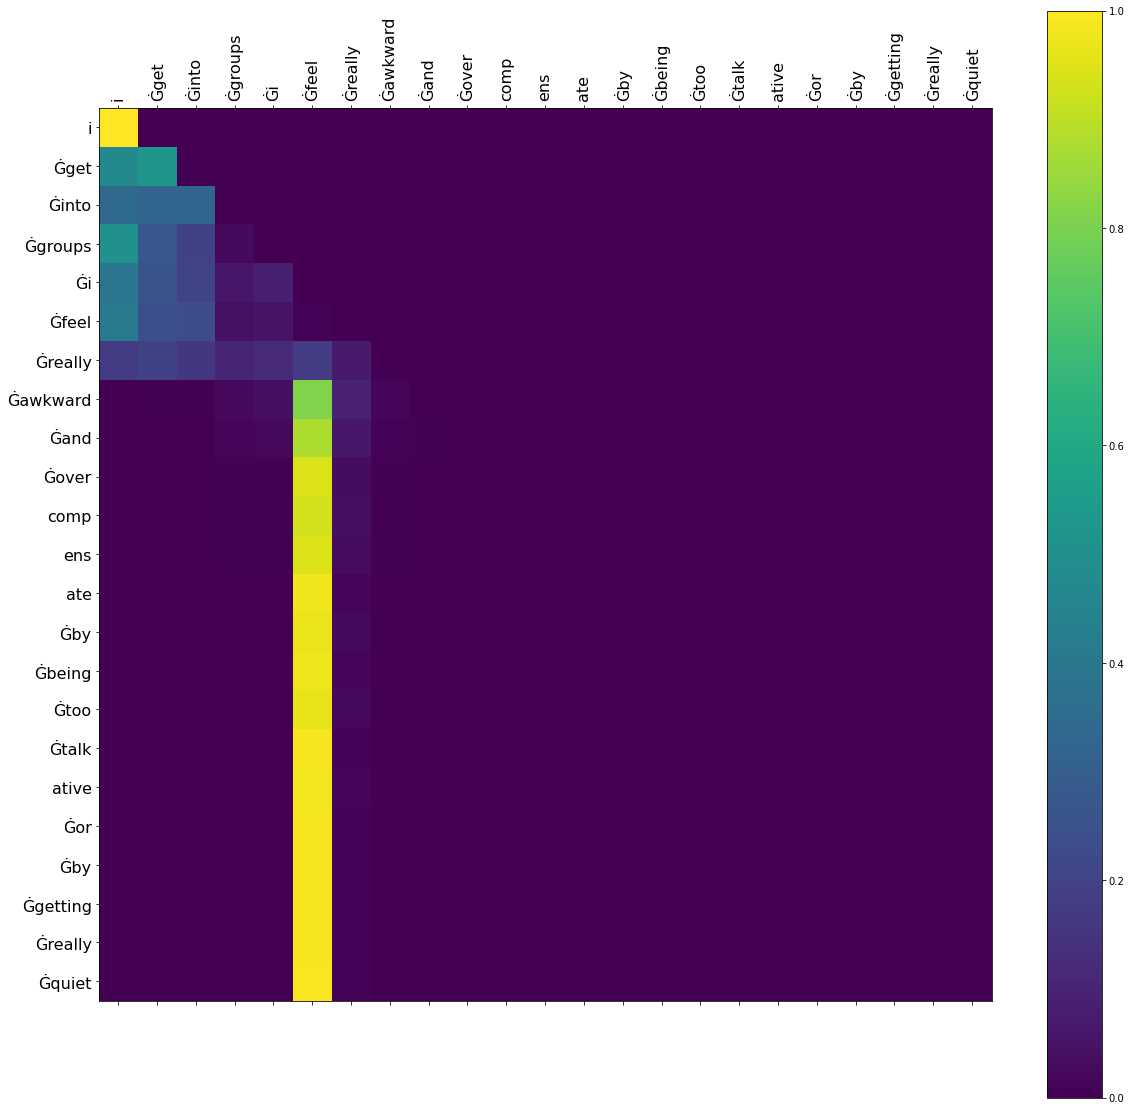

In [42]:
attns = get_attention_matrixes(model_0, tokenizer, text)
show_attention(tokens, attns[-1][0])

## Fine-tuning

Теперь другой подход: загрузим модель, которая обучалась решать задачу Language Modeling. Посмотрим, получим ли мы прирост в качестве.

In [43]:
model_1 = GPT2ForSequenceClassification.from_pretrained(
    "distilgpt2", 
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=8
).to(device)

Downloading:   0%|          | 0.00/336M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
lr = 1e-5 # Предполагаемый learning rate. Он может быть больше или меньше :)

optimizer = torch.optim.Adam(model_1.parameters(), lr)
criterion = torch.nn.CrossEntropyLoss()
# scheduler = ... # Можно добавить шедулер для обучения моделей. Это на твое усмотрение

Вывод модели ничем не отличается от предыдущего случая, поэтому сразу приступаем к обучению:

In [47]:
from tqdm.notebook import tqdm

num_epochs = 10
# Train loop
for e in range(num_epochs):
    model_1.train()
    train_loss = 0
    train_total = 0
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        output = model_1(batch["input_ids"].to(device), attention_mask=batch["mask"].to(device))
        loss = criterion(output["logits"], batch["target"].to(device))
        train_loss += loss.item()
        train_total += len(batch["target"])
        loss.backward()
        optimizer.step()
    
        
        
    valid_loss = 0
    valid_acc = 0
    valid_total = 0
    model_1.eval()
    with torch.no_grad():
        for batch in valid_loader:
            output = model_1(batch["input_ids"].to(device), attention_mask=batch["mask"].to(device))
            loss = criterion(output["logits"], batch["target"].to(device))
            valid_loss += loss.item()
            valid_acc += (batch["target"].to(device) == output["logits"].argmax(axis=1)).sum().item()
            valid_total += len(batch["target"])
            

    print(f"Train Loss: {train_loss / (train_total)}, "
          f"Valid Loss: {valid_loss / (valid_total)}, "
          f"Valid Acc: {valid_acc / (valid_total)}")
    
    
        
# Testing
test_acc = 0
test_total = 0
model_1.eval()
with torch.no_grad():
    for batch in test_loader:
        output = model_1(batch["input_ids"].to(device), attention_mask=batch["mask"].to(device))
        test_acc += (batch["target"].to(device) == output["logits"].argmax(axis=1)).sum().item()
        test_total += len(batch["target"])
        
print(f"\n\nTest Acc: {test_acc / test_total}")



Test Acc: 0.1893125


Есть ли прирост качества или скорости обучения?

Посмотри на карты внимания. Есть ли отличие от предыдущего случая?

In [48]:
text = emotion_dataset["train"]["text"][123] # Выбери текст из датасета
tokens = tokenizer.tokenize(text)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


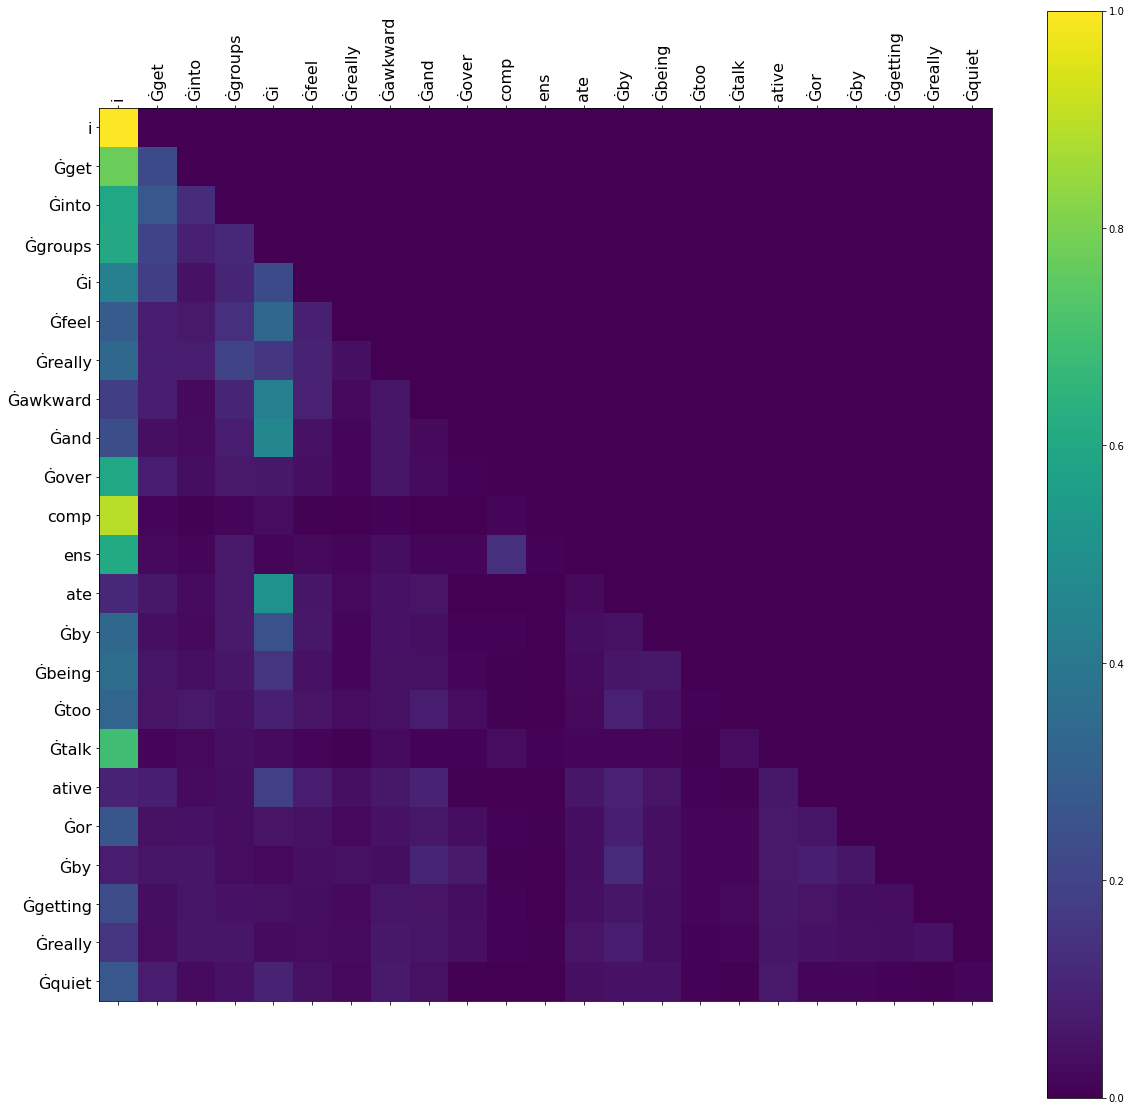

In [49]:
attns = get_attention_matrixes(model_1, tokenizer, text)
show_attention(tokens, attns[-1][0])

## Отчет

Покажи здесь, что ты выполнил по этой работе. Ответь на несколько вопросов:
- Какой подход оказался лучше? 
- На какие слова модель большего всего обращала внимание?
- На каких слоях/головах модель обращала внимание?

< твой отчет/ответы >

In [ ]:
Первый подход оказался на порядок лучше, во втором варианте сеть практически не обучалась. На приведенном примере